In [2]:
%load_ext  autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from pandas_summary import DataFrameSummary
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 400)
sns.set()

os.chdir('../')
print(os.getcwd())
from src import utils
from src import headers

from scipy import stats
from scipy.stats import norm, skew #for some statistics


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
from subprocess import check_output

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/jchu/projects/kaggle-house-prices


In [3]:
RAW       = 'data/raw'
INTERIM   = 'data/interim'
PROCESSED = 'data/processed'

In [4]:
train     = pd.read_csv(f'{RAW}/train.csv')
test      = pd.read_csv(f'{RAW}/test.csv')

In [13]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [17]:
from src import utils

In [29]:
cols = utils.get_cat_features(train).columns

labels = []

split = len(cols)

for i in range(0, split):
    df_trn = train[cols[i]].unique()
    df_tst = test[cols[i]].unique()
    labels.append(list(set(df_trn) | set(df_tst)))

In [30]:
labels

[['RH', nan, 'FV', 'RL', 'C (all)', 'RM'],
 ['Grvl', 'Pave'],
 [nan, 'Grvl', 'Pave'],
 ['IR1', 'IR2', 'IR3', 'Reg'],
 ['Lvl', 'Low', 'HLS', 'Bnk'],
 [nan, 'AllPub', 'NoSeWa'],
 ['Inside', 'FR3', 'FR2', 'CulDSac', 'Corner'],
 ['Sev', 'Gtl', 'Mod'],
 ['NoRidge',
  'Blueste',
  'Blmngtn',
  'Crawfor',
  'StoneBr',
  'SawyerW',
  'NPkVill',
  'Sawyer',
  'Timber',
  'Gilbert',
  'IDOTRR',
  'BrDale',
  'ClearCr',
  'Somerst',
  'NridgHt',
  'OldTown',
  'NWAmes',
  'MeadowV',
  'SWISU',
  'NAmes',
  'CollgCr',
  'BrkSide',
  'Veenker',
  'Edwards',
  'Mitchel'],
 ['Norm', 'Artery', 'RRAe', 'RRAn', 'RRNn', 'Feedr', 'PosA', 'PosN', 'RRNe'],
 ['Norm', 'Artery', 'RRAn', 'RRAe', 'RRNn', 'Feedr', 'PosA', 'PosN'],
 ['Duplex', 'Twnhs', '1Fam', '2fmCon', 'TwnhsE'],
 ['2.5Unf',
  '1Story',
  '2.5Fin',
  '2Story',
  '1.5Unf',
  'SFoyer',
  'SLvl',
  '1.5Fin'],
 ['Hip', 'Gable', 'Shed', 'Mansard', 'Flat', 'Gambrel'],
 ['CompShg',
  'Membran',
  'WdShngl',
  'ClyTile',
  'WdShake',
  'Tar&Grv',
  'Meta

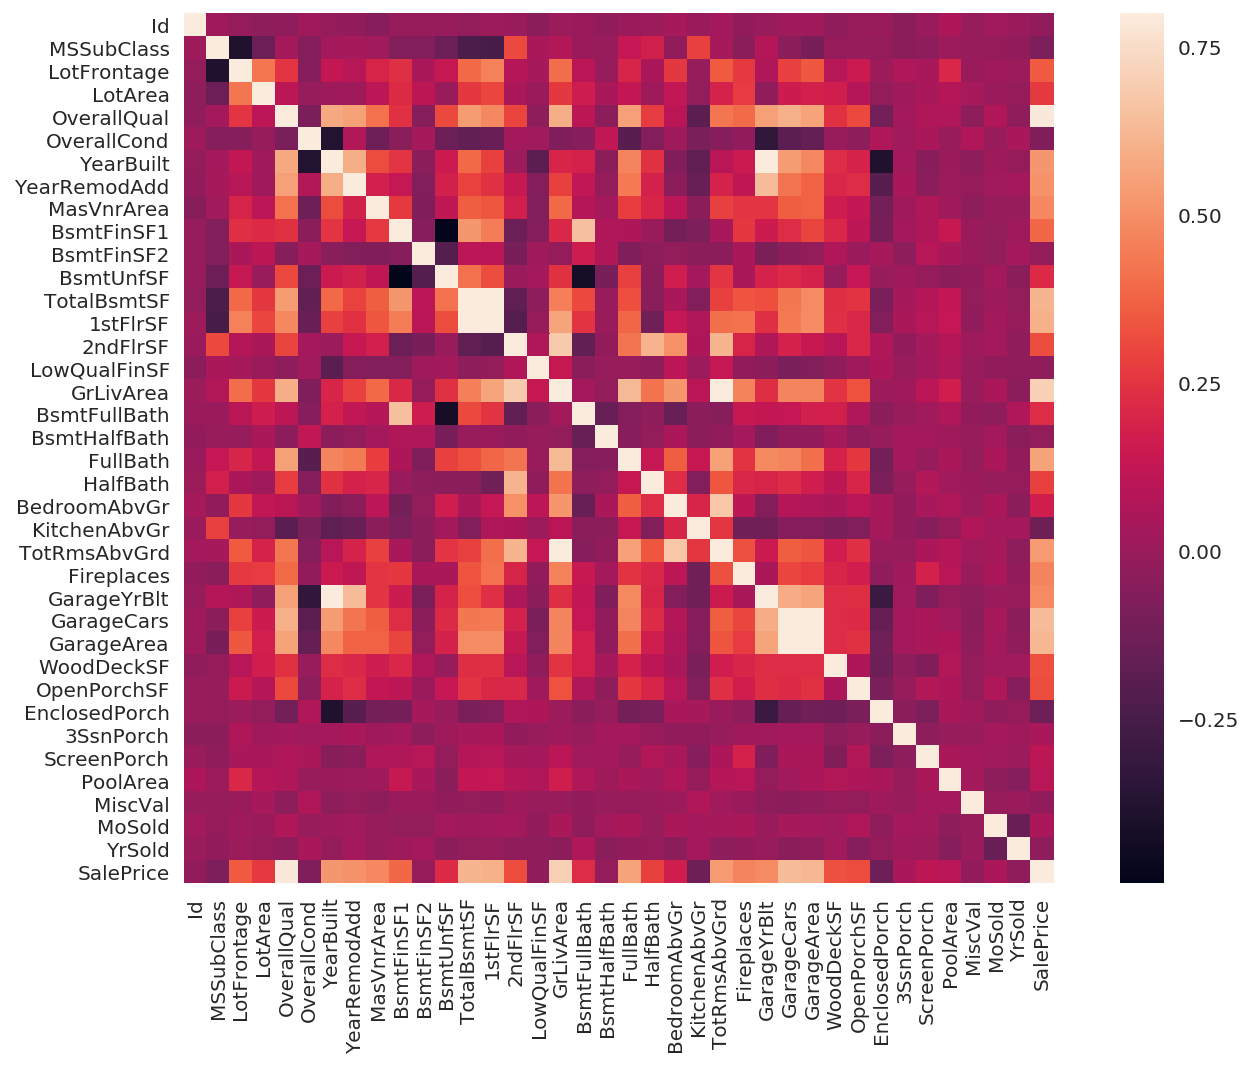

In [35]:
corr_mat = train.corr()
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(corr_mat, vmax=.8, square=True)

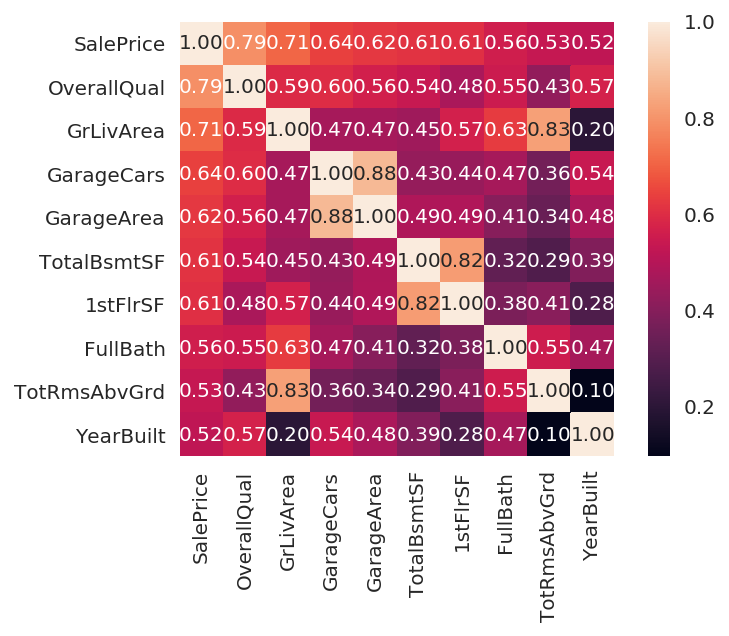

In [49]:
k = 10

cols = corr_mat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.0)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

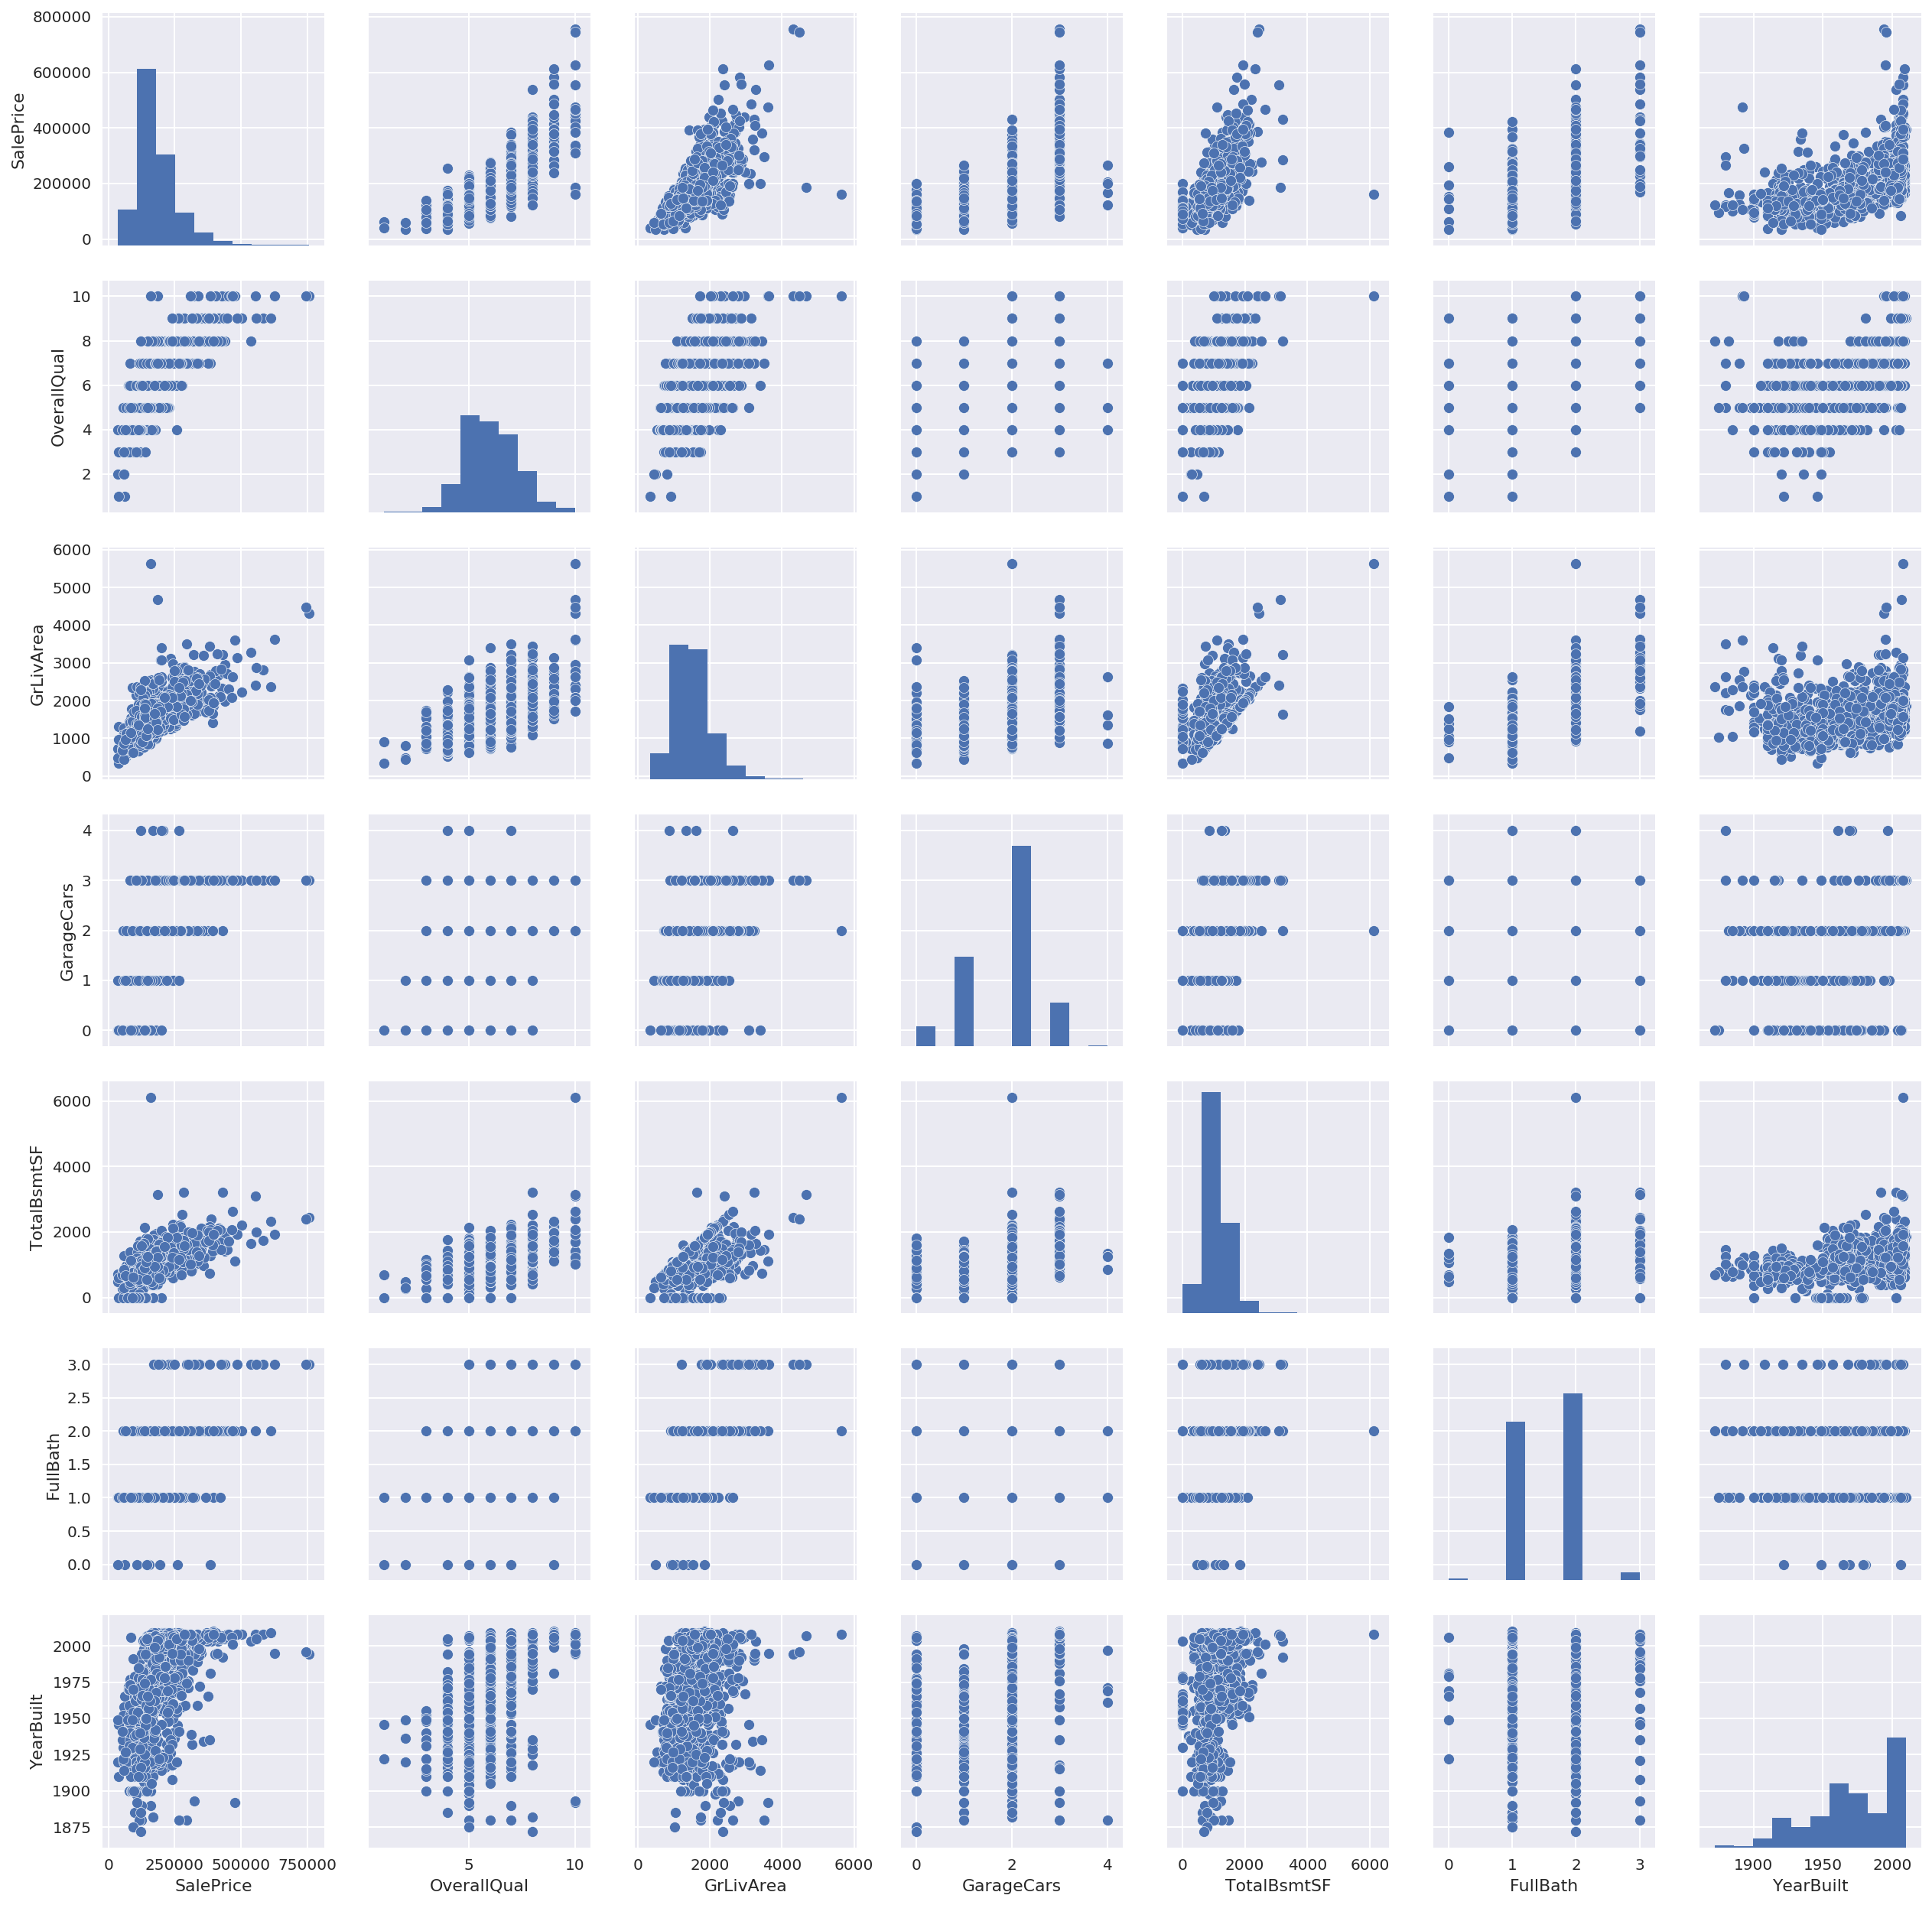

In [50]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size=2.5)
plt.show()

In [53]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
missing = utils.count_missing(train)

In [60]:
missing[missing['Percent']>0]

,Total,Percent
PoolQC,1453,0.995
MiscFeature,1406,0.963
Alley,1369,0.938
Fence,1179,0.808
FireplaceQu,690,0.473
LotFrontage,259,0.177
GarageCond,81,0.055
GarageType,81,0.055
GarageYrBlt,81,0.055
GarageFinish,81,0.055


TotalBsmtSF and 1stFlrSF = 0.82
YearBuilt and YearRemodAdd = 0.59
OverallQual and YearBuilt = 0.57
OverallQual and YearRemodAdd = 0.55
OverallQual and TotalBsmtSF = 0.54
BsmtFinSF1 and TotalBsmtSF = 0.52


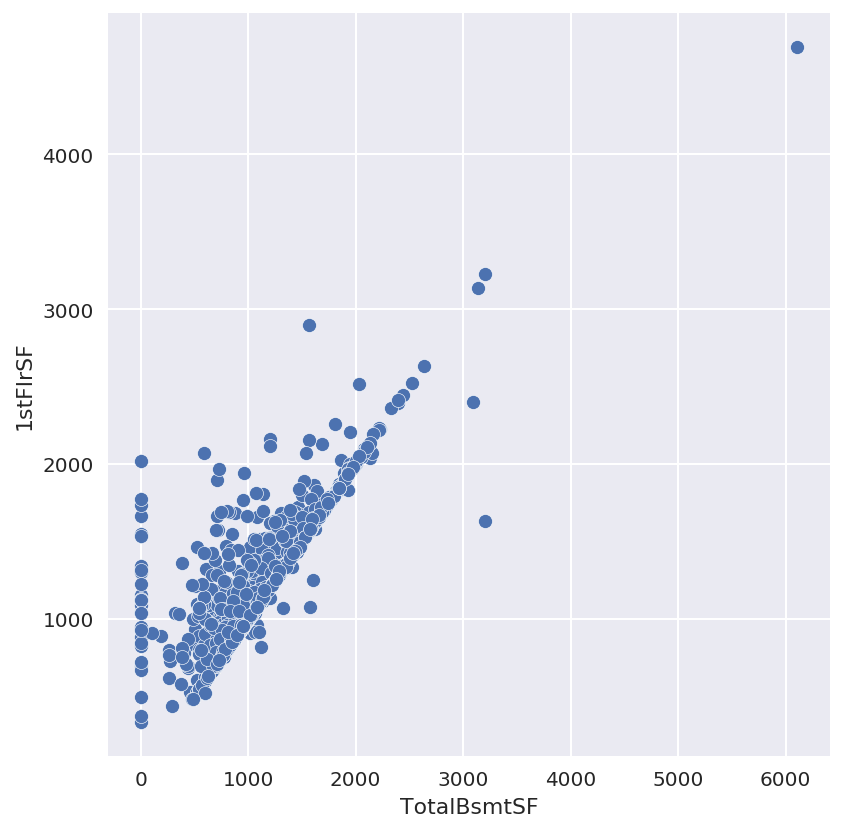

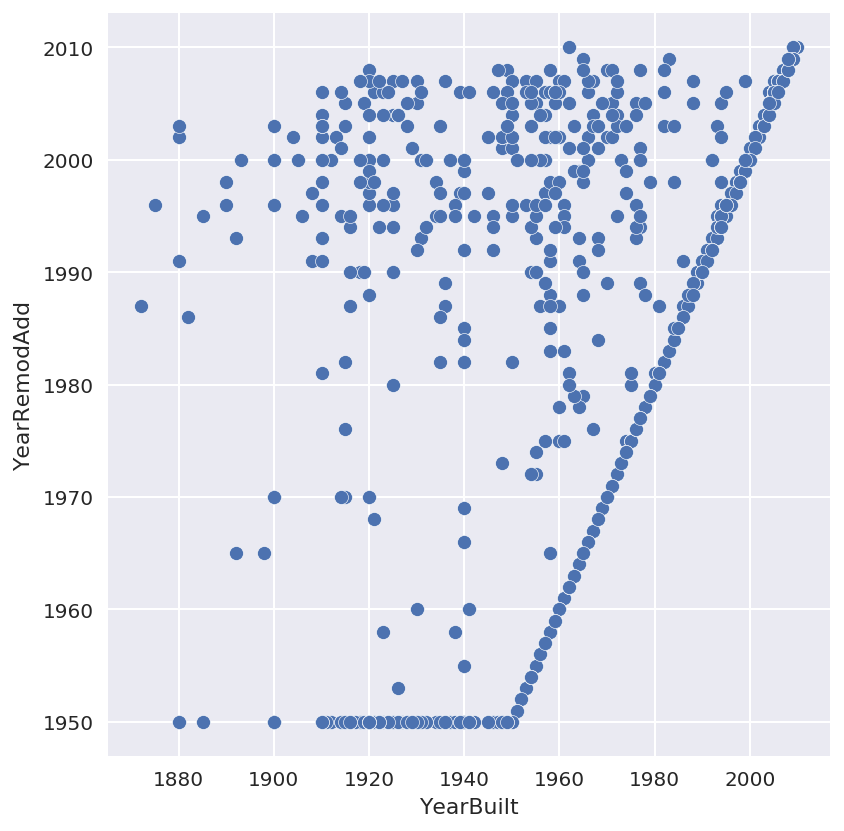

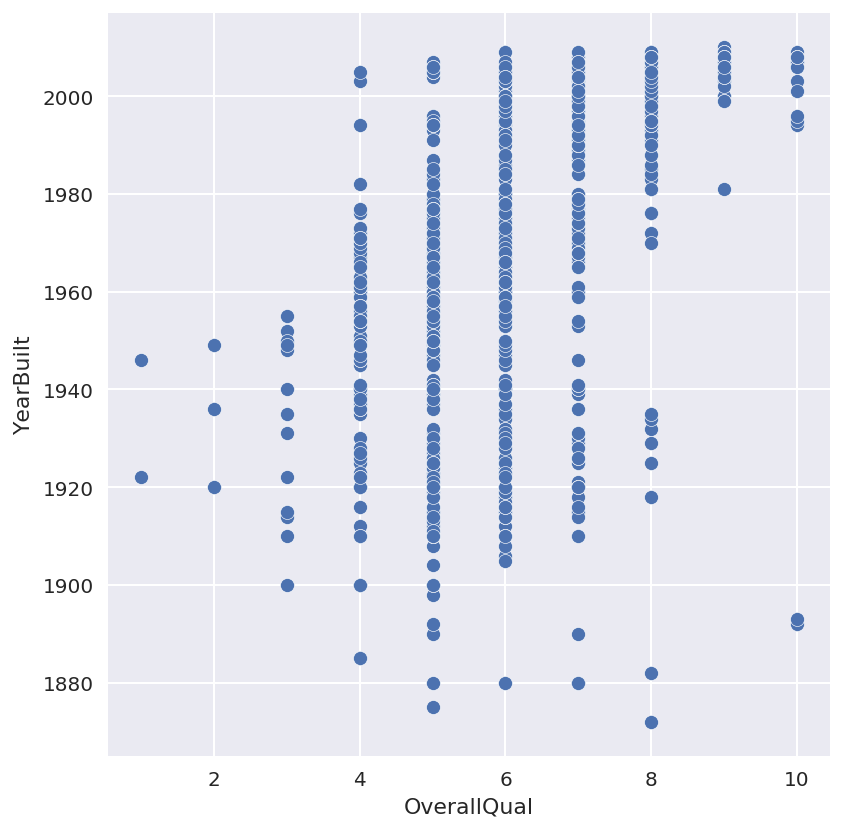

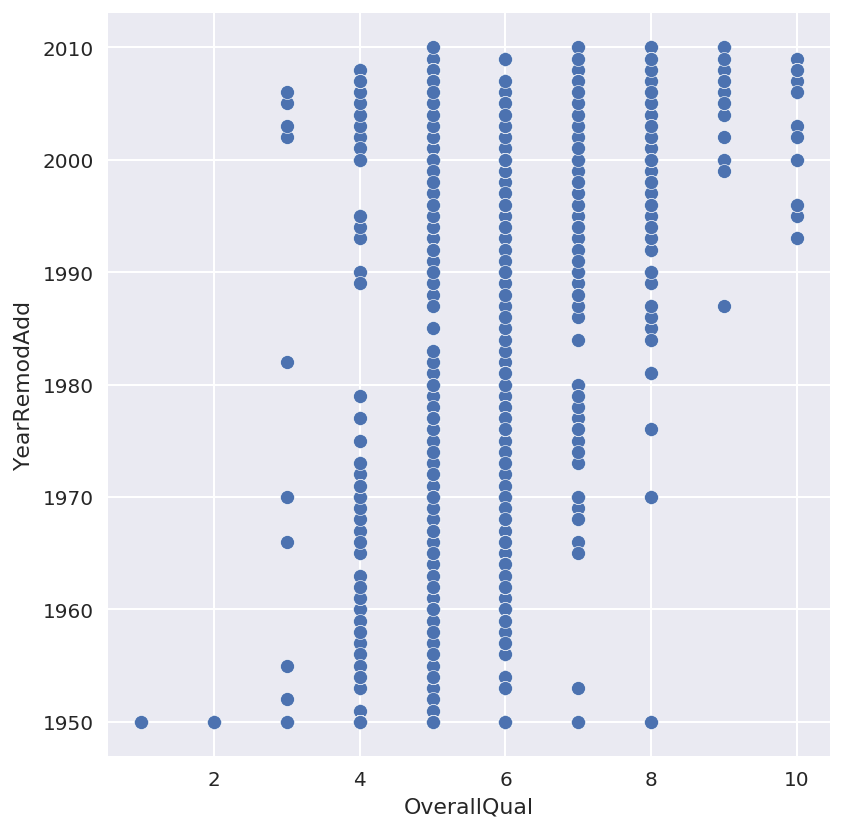

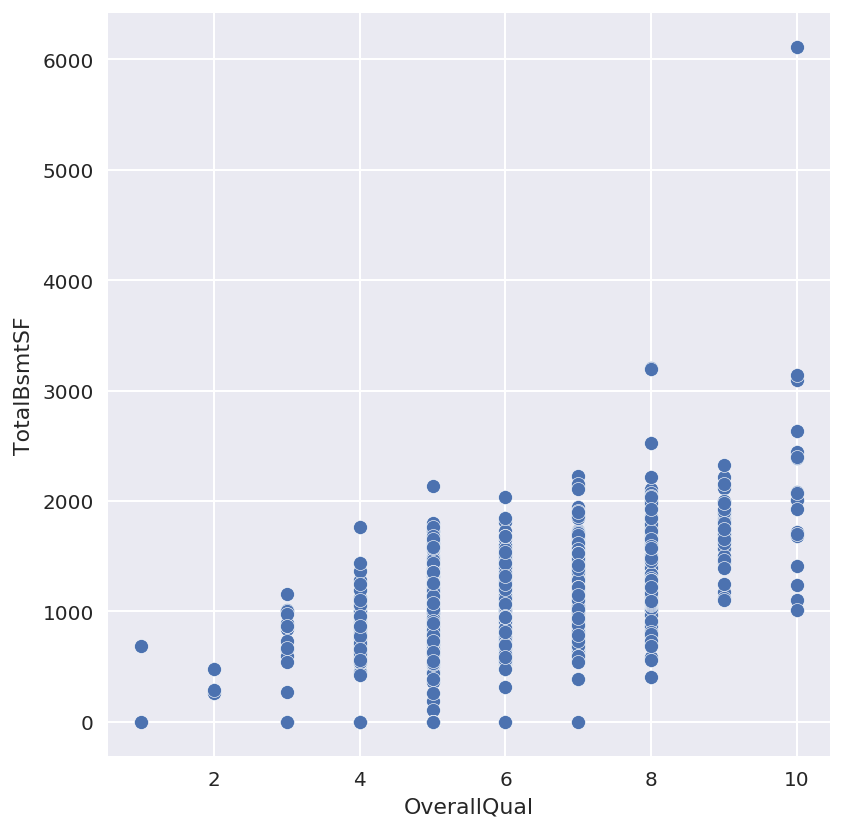

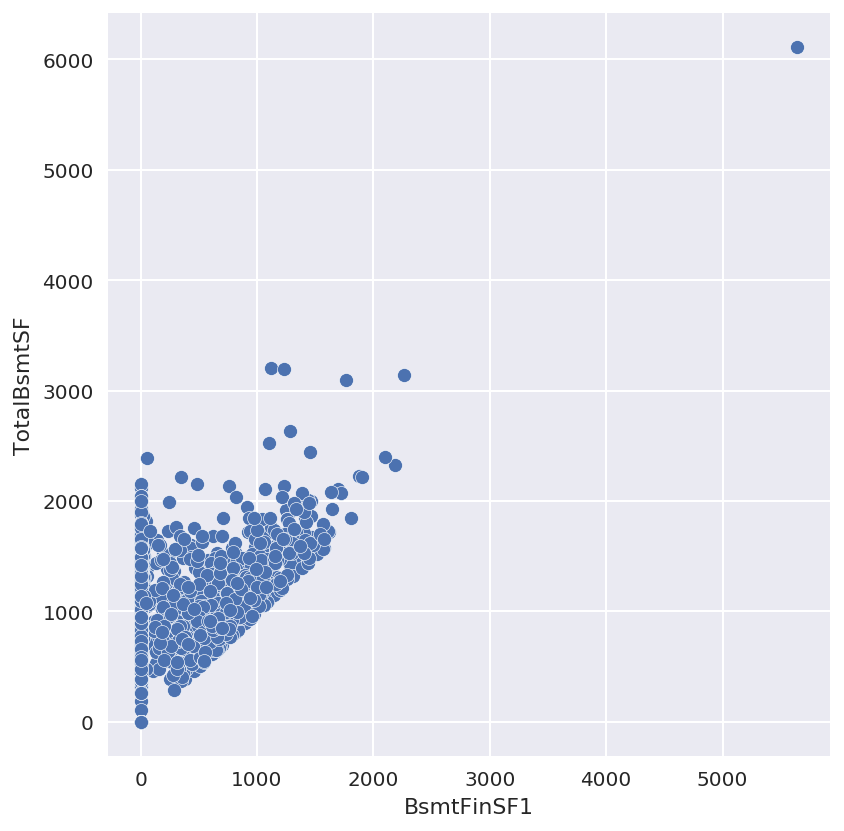

In [65]:
utils.plot_high_correlations(train)